In [1]:
from fittingutil import *
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from scipy.optimize import nnls

count 50


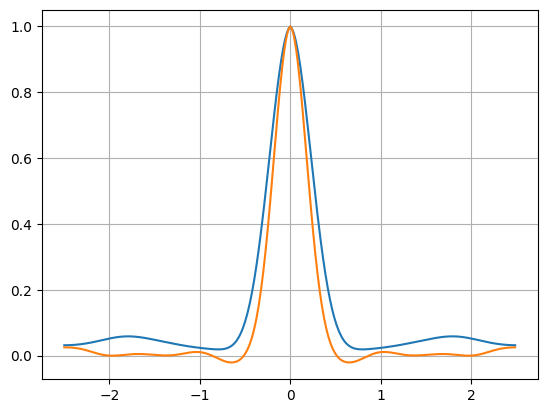

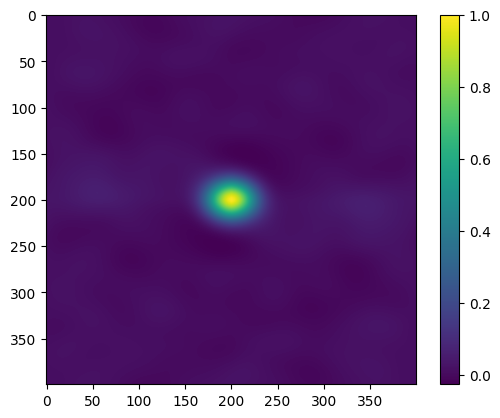

In [6]:
directory = 'fiber1/thetai0_patch/'
Ly = 5
Lz = 5
Ny = 400
Nz = 400
dy = Ly/Ny
dz = Lz/Nz
df = 1/Ly
yvec = np.linspace(-Ly/2, Ly/2-dy, Ny)
zvec = np.linspace(-Lz/2, Lz/2-dz, Nz)

instancenum = 50
thetanum = 400
phinum = 400
indextheta = thetanum // 2
indexphi = phinum // 2
lambdaindex = 0
thetai = 0
thetah = 0
phih = 180
mean = np.zeros((thetanum, phinum))
noisemat = np.zeros((thetanum, phinum, instancenum), dtype=float)
count = 0
for i in range(0, instancenum):
    try:
        fileName = directory +  'lambda'+str(lambdaindex)+ \
            '/TM_'+str(i+1)+'_thetai_'+str(thetai)+'_thetah_'+str(thetah)+'_phih_'+str(phih)+'.binary'        
        intensity = np.fromfile(fileName, dtype="float32")
        intensity = intensity.reshape(Nz, Ny)   
        noisemat[:,:,count] = intensity
        mean = mean + intensity
        count += 1
    except:
        print(i)
        continue
mean = mean/count
print("count", count)

Fnoiseaverage = np.zeros((thetanum, phinum))
for i in range(count):
    noise = noisemat[:,:,i]
    Fnoise = np.abs(ForwardFFT_shifted(noise-mean))
    Fnoiseaverage = Fnoiseaverage + Fnoise/instancenum
acf_from_FT = np.real(ForwardFFT_shifted(Fnoiseaverage**2))

acf = acf_from_FT / np.max(acf_from_FT)
fig = plt.figure()
plt.plot(yvec, acf[indextheta,:])
plt.plot(yvec, acf[:,indexphi])
plt.grid()

fig = plt.figure()
plt.imshow(acf)
plt.colorbar()
plt.show()

np.save('intensitycor_h0.2_l2_phih_'+str(phih)+'_lambda'+str(lambdaindex)+'.npy', acf)


/home/xia/.local/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


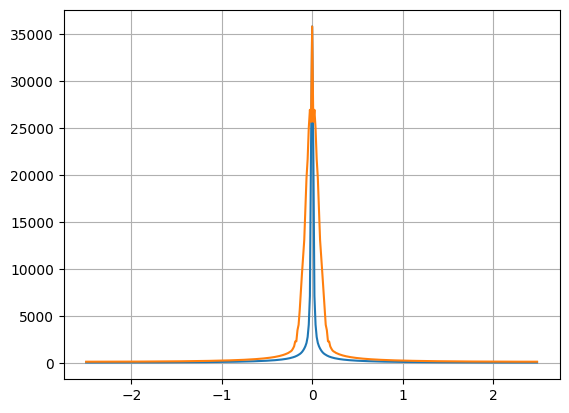

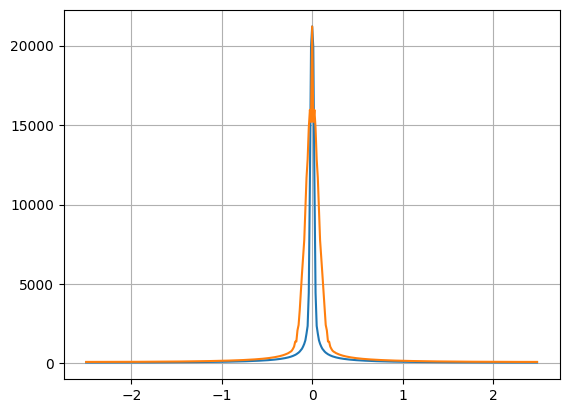

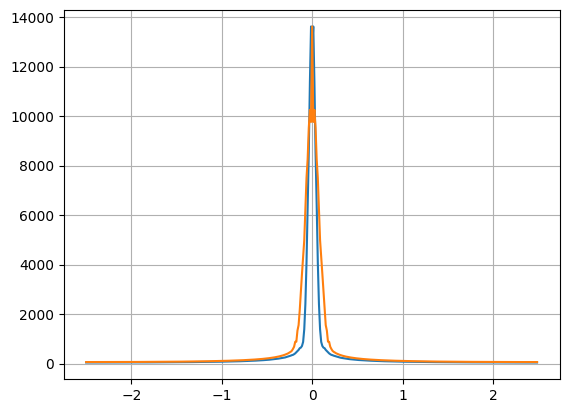

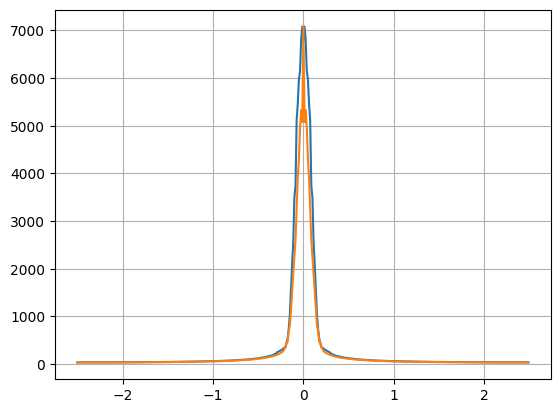

In [7]:
# plot lowest frequency band
sqrtFacf = np.sqrt(InverseFFT_shifted(acf))

directoryroot = 'noise/fiber1/'
# compute mean
bandnum = 4
instancenum = 100
meanmat = np.zeros((thetanum, phinum, bandnum), dtype=float)
noisemat = np.zeros((thetanum, phinum, instancenum, bandnum), dtype=float)
for index in range(0, bandnum):
    mean = np.zeros((thetanum, phinum))
    for i in range(instancenum):
        directory = directoryroot + 'band' + str(index)
        fileName = directory + "/wavelet"+str(i)+".binary"
        noise = np.fromfile(fileName, dtype="float32")
        noise = noise.reshape(thetanum, phinum)
                
        mean = mean + noise/instancenum
        noisemat[:,:,i, index] = noise
    meanmat[:,:,index] = mean

# read in single bands
Fnoiseaveragemat = np.zeros((thetanum, phinum, bandnum), float)
for index in range(0, bandnum):
    directory = directoryroot + 'band' + str(index) + '/'
    Fnoiseaverage = np.zeros((thetanum, phinum), float)
    for i in range(instancenum):
        noise = noisemat[:,:,i, index]
        Fnoise = np.abs(ForwardFFT_shifted(noise-meanmat[:,:,index]))
        Fnoiseaverage = Fnoiseaverage + Fnoise/instancenum
    curacf = np.real(ForwardFFT_shifted(Fnoiseaverage**2))

    plt.plot(yvec, Fnoiseaverage[:, phinum//2])
    plt.plot(yvec, sqrtFacf[:, Ny//2]*np.max(Fnoiseaverage[:, phinum//2])/np.max(sqrtFacf[:, Ny//2]))
    plt.grid()
    plt.show()
    Fnoiseaveragemat[:,:,index] = Fnoiseaverage


weight [0.43561912 0.         0.         1.47829899]


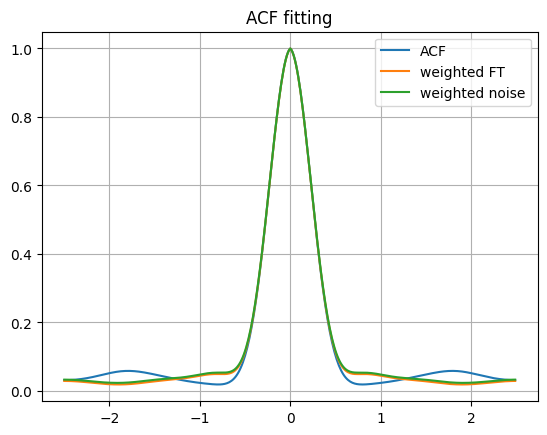

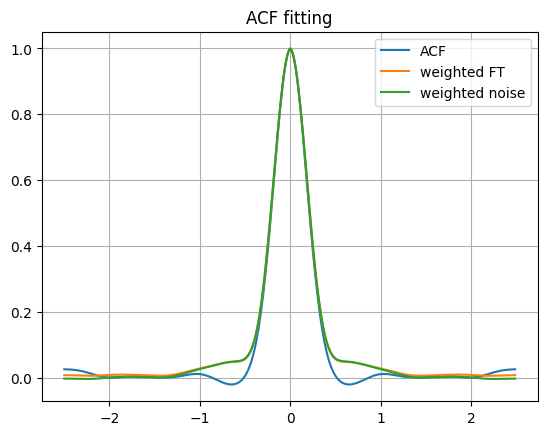

In [9]:
# fit ACF directly
gap = 200
indexstart = Ny//2-gap
indexend = Ny//2+gap
# fitting process (phi)
# collect data point [N]
sqrtFacfvec = np.zeros(indexend-indexstart,)
for index in range(indexstart, indexend):
    sqrtFacfvec[index-indexstart] = acf[indextheta, index]
# collect curve values [MN], M is the number of curves
valuemat = np.zeros((indexend-indexstart, bandnum))
for index in range(indexstart, indexend):
    for i in range(bandnum):
        curacf = np.real(ForwardFFT_shifted(Fnoiseaveragemat[:,:,i]**2))
        valuemat[index-indexstart, i] = curacf[indextheta, index]

weight = nnls(valuemat, sqrtFacfvec)[0]
weight = np.sqrt(weight)

noisemat_new, mean = weightedsum(thetanum, phinum, instancenum, noisemat, bandnum, weight)

meanmat = np.mean(noisemat_new, axis=2)
scale = 1 / np.mean(meanmat)   # scaling the weights all together does not change ACF, 
                               # determine the scale factor by ensureing mean is 1
weight = weight * scale
print("weight", weight)

weightedFT, acf_weighted_FT = ACFweightedFT(thetanum, phinum, Fnoiseaveragemat, bandnum, weight)
noisemat_new, mean = weightedsum(thetanum, phinum, instancenum, noisemat, bandnum, weight)


# # compute ACF using FT
Fnoiseaverage, acf_from_FT = ACFfromFT(thetanum, phinum, instancenum, noisemat_new, mean)
indextheta = thetanum // 2
indexphi = phinum // 2
fig = plt.figure()
plt.plot(yvec, acf[indextheta, :])
plt.plot(yvec, acf_weighted_FT[indextheta, :]/np.max(acf_weighted_FT[indextheta, :]))
plt.plot(yvec, acf_from_FT[indextheta,:]/np.max(acf_from_FT[indextheta,:]))
plt.grid()
plt.legend(('ACF', 'weighted FT', 'weighted noise'))
plt.title('ACF fitting')
plt.show()

fig = plt.figure()
plt.plot(yvec, acf[:, indexphi])
plt.plot(yvec, acf_weighted_FT[:, indexphi]/np.max(acf_weighted_FT[:, indexphi]))
plt.plot(yvec, acf_from_FT[:, indexphi]/np.max(acf_from_FT[:, indexphi]))
plt.grid()
plt.legend(('ACF', 'weighted FT', 'weighted noise'))
plt.title('ACF fitting')
plt.show()